IMPORTING LIBRARIES

In [53]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import docx
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
from torchmetrics.image.kid import KernelInceptionDistance
import cv2
from skimage.metrics import structural_similarity as ssim
import lpips
from scipy.fft import fft2, fftshift
import statistics
import seaborn as sns

CONVERTING PDF PAGES TO IMAGES

In [2]:
PDF_DIR = "/home/aniketj/GSOC_TASK3/PDFs/"  # Directory containing PDFs
IMAGE_DIR = "/home/aniketj/GSOC_TASK3/IMAGES/"  # Output directory for images

os.makedirs(IMAGE_DIR, exist_ok=True)

In [3]:
def pdf_to_images(pdf_path, output_folder, dpi=250):
    images = convert_from_path(pdf_path, dpi=dpi, fmt="jpeg")  
    image_paths = []
    
    for i, img in enumerate(images):
        img = img.convert("RGB")  
        img_path = os.path.join(output_folder, f"{os.path.basename(pdf_path).replace('.pdf', '')}_page_{i+1}.jpg")
        img.save(img_path, "JPEG", quality=85)  
        image_paths.append(img_path)
    
    return image_paths

In [4]:
# Process all PDFs in the folder
for pdf in os.listdir(PDF_DIR):
    if pdf.endswith(".pdf"):
        pdf_to_images(os.path.join(PDF_DIR, pdf), IMAGE_DIR, dpi=250)

print(" PDF to Image Conversion Done!")

/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (147000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 PDF to Image Conversion Done!


TEXT EMBEDDINGS

In [5]:
# Load BERT model and tokenizer for text embeddings
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [6]:
# Function to extract text from docx files
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    text = " ".join([p.text for p in doc.paragraphs])
    return text

In [7]:
# Function to generate text embeddings
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  

In [8]:
# Dataset class incorporating both images and text embeddings
class TextImageDataset(Dataset):
    def __init__(self, img_dir, txt_dir, transform=None):
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.txt_paths = {os.path.splitext(f)[0]: os.path.join(txt_dir, f) for f in os.listdir(txt_dir) if f.endswith('.docx')}
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        doc_name = os.path.splitext(os.path.basename(img_path))[0]
        text_embedding = torch.zeros((1, 768))  
        if doc_name in self.txt_paths:
            text = extract_text_from_docx(self.txt_paths[doc_name])
            text_embedding = get_text_embedding(text)
        
        return image, text_embedding.squeeze(0)

In [9]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

CREATING DATALOADER

In [10]:
# Load dataset
dataset = TextImageDataset(img_dir="/home/aniketj/GSOC_TASK3/IMAGES", txt_dir="/home/aniketj/GSOC_TASK3/TRANSCRIPTIONS", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print("Dataset loaded with images and text embeddings")

Dataset loaded with images and text embeddings


GENERATOR MODEL

In [11]:
# Generator model
class Generator(nn.Module):
    def __init__(self, input_channels=3, text_dim=768, output_channels=3, num_residual_blocks=6):
        super(Generator, self).__init__()
        self.text_fc = nn.Linear(text_dim, 256 * 256)  # Embed text into image size
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels + 1, 64, kernel_size=7, stride=1, padding=3),  # +1 for text map
            nn.ReLU(inplace=True)
        )
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        self.final = nn.Sequential(
            nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x, text):
        text_map = self.text_fc(text).view(-1, 1, 256, 256)  # Reshape to match image
        x = torch.cat([x, text_map], dim=1)  # Concatenate text representation with image
        x = self.initial(x)
        x = self.residual_blocks(x)
        return self.final(x)

RESIDUAL BLOCKS

In [12]:
# Residual block for generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

DISCRIMINATOR MODEL

In [13]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [21]:
# Function to generate text-based images
def generate_text_image(model, test_image_path, img_name):
    model.eval()
    image = Image.open(test_image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        fake_image = model(image, torch.zeros(1, 768).to(device))

    save_image(fake_image, img_name)
    print(f"Saved: {img_name}")

In [15]:
# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

In [16]:
# Loss and optimizers
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
GEN_IMAGE_DIR = "/home/aniketj/GSOC_TASK3/GENERATED_IMAGES/"  # Output directory for images

os.makedirs(GEN_IMAGE_DIR, exist_ok=True)

GAN TRAINING

In [18]:
# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    for i, (real_text_images, text_embeddings) in enumerate(dataloader):
        real_text_images, text_embeddings = real_text_images.to(device), text_embeddings.to(device)

        # Generate fake images
        fake_text_images = G(real_text_images, text_embeddings)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion_GAN(D(real_text_images), torch.ones_like(D(real_text_images)))
        fake_loss = criterion_GAN(D(fake_text_images.detach()), torch.zeros_like(D(fake_text_images)))
        D_loss = (real_loss + fake_loss) / 2
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        G_loss = criterion_GAN(D(fake_text_images), torch.ones_like(D(fake_text_images))) + \
                 criterion_cycle(fake_text_images, real_text_images) * 10
        G_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {D_loss.item()}, G Loss: {G_loss.item()}")

    save_image(fake_text_images, f"/home/aniketj/GSOC_TASK3/GENERATED_IMAGES/fake_img_{epoch+1}.png")

Epoch [1/150], D Loss: 0.6956725120544434, G Loss: 6.836447715759277


/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (147000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [2/150], D Loss: 0.6689680218696594, G Loss: 2.441878318786621
Epoch [3/150], D Loss: 0.6986599564552307, G Loss: 1.883784532546997
Epoch [4/150], D Loss: 0.713148832321167, G Loss: 2.235975742340088
Epoch [5/150], D Loss: 0.6587569713592529, G Loss: 1.5896402597427368
Epoch [6/150], D Loss: 0.6643038392066956, G Loss: 2.2006261348724365
Epoch [7/150], D Loss: 0.6772604584693909, G Loss: 1.6532434225082397
Epoch [8/150], D Loss: 0.6940268278121948, G Loss: 1.5540859699249268
Epoch [9/150], D Loss: 0.6916257739067078, G Loss: 1.6482093334197998
Epoch [10/150], D Loss: 0.6761627197265625, G Loss: 1.9304237365722656
Epoch [11/150], D Loss: 0.6959398984909058, G Loss: 1.4095277786254883
Epoch [12/150], D Loss: 0.6859136819839478, G Loss: 1.7537250518798828
Epoch [13/150], D Loss: 0.6915051937103271, G Loss: 2.1146504878997803
Epoch [14/150], D Loss: 0.6926771402359009, G Loss: 1.4791086912155151
Epoch [15/150], D Loss: 0.6916489601135254, G Loss: 1.4242699146270752
Epoch [16/150], D 

SAVING THE GENERATOR AND DISCRIMINATOR MODEL

In [20]:
# Save trained models
torch.save(G.state_dict(), "/home/aniketj/GSOC_TASK3/generator_renaissance.pth")
torch.save(D.state_dict(), "/home/aniketj/GSOC_TASK3/discriminator_renaissance.pth")
print("Models saved successfully!")

Models saved successfully!


In [23]:
# Generate text-based image
generate_text_image(G, "/home/aniketj/GSOC_TASK3/TEST_IMAGES/9.jpg","generated_renaissance_image9.png")

Saved: generated_renaissance_image9.png


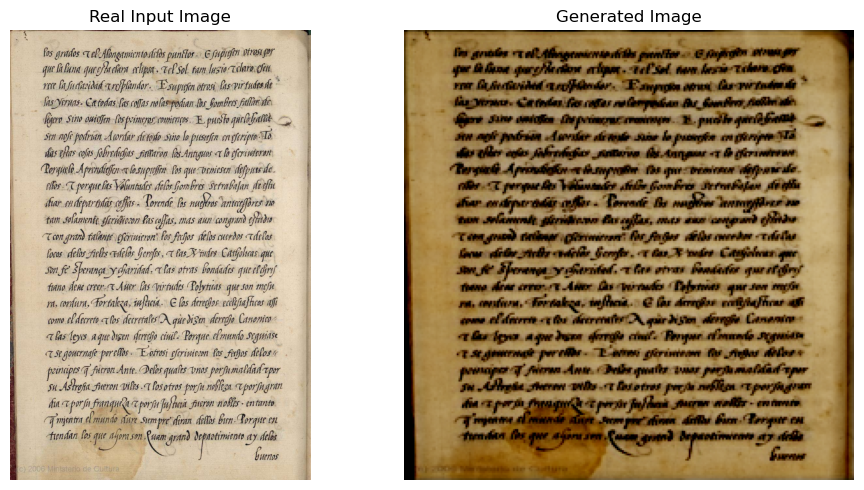

In [24]:
real_image_path = '/home/aniketj/GSOC_TASK3/TEST_IMAGES/9.jpg'
generated_image_path = '/home/aniketj/GSOC_TASK3/JUPYTER NOTEBOOK/generated_renaissance_image9.png'

real_img_bgr = cv2.imread(real_image_path)
gen_img_bgr = cv2.imread(generated_image_path)

real_img = cv2.cvtColor(real_img_bgr, cv2.COLOR_BGR2RGB)
gen_img = cv2.cvtColor(gen_img_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(real_img)
axes[0].set_title('Real Input Image')
axes[0].axis('off')

axes[1].imshow(gen_img)
axes[1].set_title('Generated Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

EVALUATION METRICS : Structural Similarity Index Measure (SSIM)

In [25]:
def calculate_ssim(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None:
        raise FileNotFoundError(f"Could not load image: {img1_path}")
    if img2 is None:
        raise FileNotFoundError(f"Could not load image: {img2_path}")

    # Resize images if they have different shapes
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    score, _ = ssim(img1, img2, full=True)
    return score

EVALUATION METRICS : Peak Signal-to-Noise Ratio (PSNR)

In [26]:
# PSNR
def calculate_psnr(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

In [27]:
# Function to load and preprocess an image for LPIPS
def load_image(image_path):
    img = cv2.imread(image_path)  # Load image (BGR format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = np.transpose(img, (2, 0, 1)) / 255.0 * 2 - 1  # Normalize to [-1,1]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
    return img

In [28]:
# Function to generate images
def generate_images(input_dir, output_dir):
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
    
    for img_name in tqdm(image_files, desc="Generating Images"):
        img_path = os.path.join(input_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            generated_image = G(image, torch.zeros(1, 768).to(device))

        save_path = os.path.join(output_dir, f"{img_name}")
        save_image(generated_image, save_path)

    print(f"Generated images saved in: {output_dir}")

In [29]:
G.eval()

Generator(
  (text_fc): Linear(in_features=768, out_features=65536, bias=True)
  (initial): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [30]:
# Load the trained generator model
G = Generator().to(device)
G.load_state_dict(torch.load("/home/aniketj/GSOC_TASK3/generator_renaissance.pth", map_location=device))
G.eval()  # Set model to evaluation mode

/tmp/ipykernel_1690547/787309532.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("/home/aniketj/GSOC_TASK3/generator_renaissance.pth", map_l

Generator(
  (text_fc): Linear(in_features=768, out_features=65536, bias=True)
  (initial): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [31]:
# Generate text-based image
generate_text_image(G, "/home/aniketj/GSOC_TASK3/TEST_IMAGES/27.jpg","generated_renaissance_image27.png")

Saved: generated_renaissance_image27.png


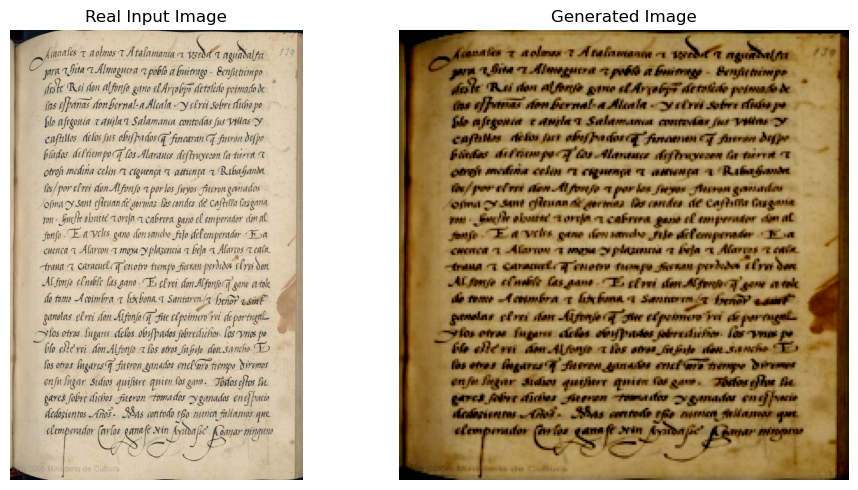

In [32]:
real_image_path = '/home/aniketj/GSOC_TASK3/TEST_IMAGES/27.jpg'
generated_image_path = '/home/aniketj/GSOC_TASK3/JUPYTER NOTEBOOK/generated_renaissance_image27.png'

real_img_bgr = cv2.imread(real_image_path)
gen_img_bgr = cv2.imread(generated_image_path)

real_img = cv2.cvtColor(real_img_bgr, cv2.COLOR_BGR2RGB)
gen_img = cv2.cvtColor(gen_img_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(real_img)
axes[0].set_title('Real Input Image')
axes[0].axis('off')

axes[1].imshow(gen_img)
axes[1].set_title('Generated Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [33]:
generate_text_image(G, "/home/aniketj/GSOC_TASK3/TEST_IMAGES/18.jpg","generated_renaissance_image18.png")

Saved: generated_renaissance_image18.png


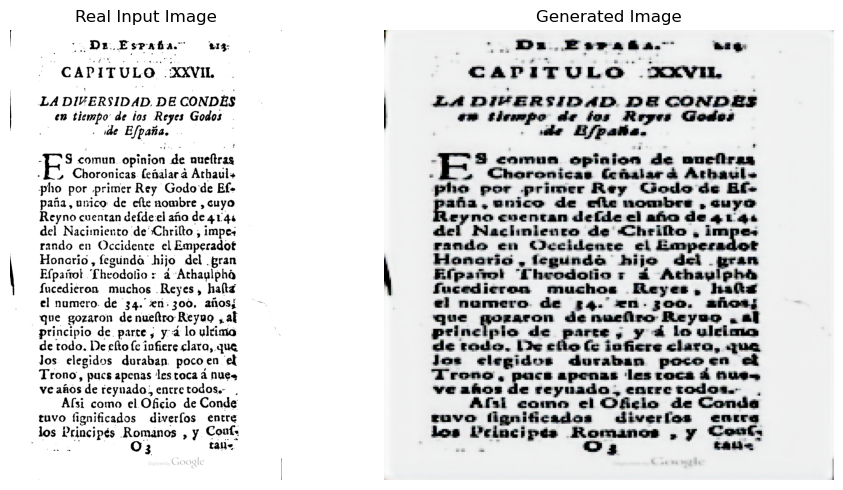

In [34]:
real_image_path = '/home/aniketj/GSOC_TASK3/TEST_IMAGES/18.jpg'
generated_image_path = '/home/aniketj/GSOC_TASK3/JUPYTER NOTEBOOK/generated_renaissance_image18.png'

real_img_bgr = cv2.imread(real_image_path)
gen_img_bgr = cv2.imread(generated_image_path)

real_img = cv2.cvtColor(real_img_bgr, cv2.COLOR_BGR2RGB)
gen_img = cv2.cvtColor(gen_img_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(real_img)
axes[0].set_title('Real Input Image')
axes[0].axis('off')

axes[1].imshow(gen_img)
axes[1].set_title('Generated Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [35]:
ssim_score = calculate_ssim(generated_image_path , real_image_path)
print("SSIM Score:", ssim_score)

SSIM Score: 0.8775161268972923


In [36]:
psnr_score = calculate_psnr(generated_image_path , real_image_path)
print("PSNR Score:" ,psnr_score)

PSNR Score: 27.306634366669755


EVALUATION METRICS : Learned Perceptual Image Patch Similarity (LPIPS)

In [37]:
# Load LPIPS model (AlexNet backbone)
loss_fn = lpips.LPIPS(net='alex') 

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, m

In [38]:
# Function to load and preprocess an image for LPIPS
def load_image(image_path):
    img = cv2.imread(image_path)  # Load image (BGR format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = np.transpose(img, (2, 0, 1)) / 255.0 * 2 - 1  # Normalize to [-1,1]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
    return img

In [39]:
real_image = load_image(real_image_path) 
fake_image = load_image(generated_image_path)

lpips_score = loss_fn(real_image, fake_image)
print("LPIPS Score:", lpips_score.item())

LPIPS Score: 0.11445092409849167


In [40]:
test_input_dir = "/home/aniketj/GSOC_TASK3/TEST_IMAGES" 
test_output_dir = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES"  # Directory to save generated images
os.makedirs(test_output_dir, exist_ok=True) 

In [41]:
generate_images(test_input_dir, test_output_dir)

Generating Images: 100%|██████████| 54/54 [00:07<00:00,  7.48it/s]

Generated images saved in: /home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES


In [42]:
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/9.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/9.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

# Resize images to match dimensions
fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

VISUALIZATIONS

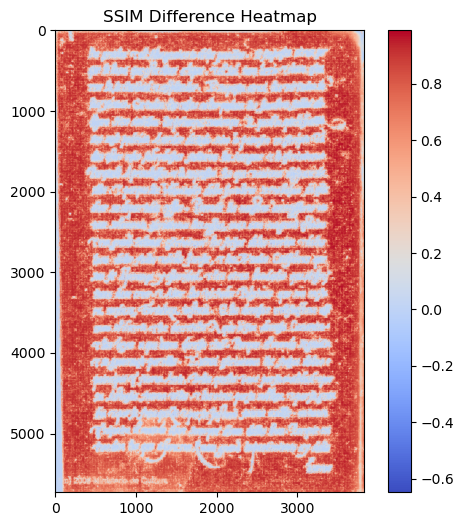

In [43]:
# SSIM Difference Heatmap 
ssim_score, ssim_diff = ssim(real_img, fake_img, full=True)
plt.figure(figsize=(6, 6))
plt.imshow(ssim_diff, cmap='coolwarm')
plt.colorbar()
plt.title("SSIM Difference Heatmap")
plt.show()

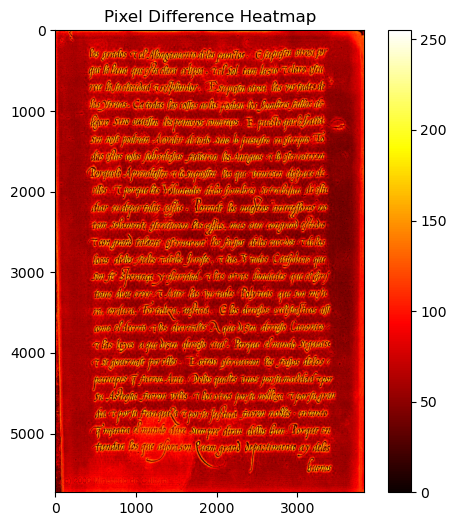

In [44]:
#  Pixel-Wise Difference Heatmap 
pixel_diff = cv2.absdiff(real_img, fake_img)
plt.figure(figsize=(6, 6))
plt.imshow(pixel_diff, cmap='hot')
plt.colorbar()
plt.title("Pixel Difference Heatmap")
plt.show()

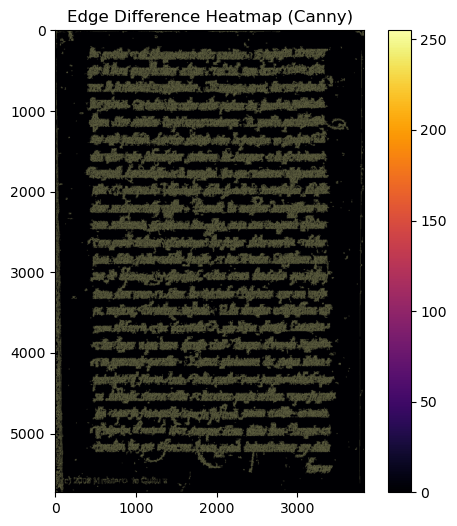

In [45]:
#  Edge Detection Heatmap 
real_edges = cv2.Canny(real_img, 50, 150)
fake_edges = cv2.Canny(fake_img, 50, 150)
edge_diff = cv2.absdiff(real_edges, fake_edges)
plt.figure(figsize=(6, 6))
plt.imshow(edge_diff, cmap='inferno')
plt.colorbar()
plt.title("Edge Difference Heatmap (Canny)")
plt.show()

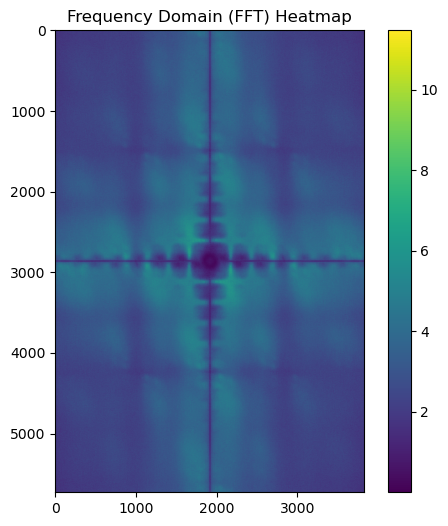

In [46]:
# Frequency Domain (FFT) Heatmap 
real_fft = np.log(np.abs(fftshift(fft2(real_img))) + 1)
fake_fft = np.log(np.abs(fftshift(fft2(fake_img))) + 1)
fft_diff = np.abs(real_fft - fake_fft)
plt.figure(figsize=(6, 6))
plt.imshow(fft_diff, cmap='viridis')
plt.colorbar()
plt.title("Frequency Domain (FFT) Heatmap")
plt.show()

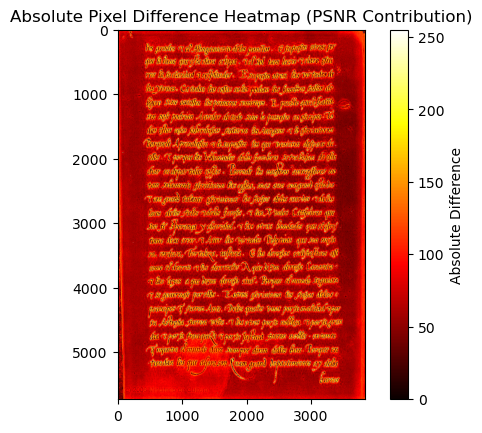

In [47]:
# Compute absolute difference map
abs_diff_map = np.abs(real_img - fake_img)

# Plot heatmap
plt.imshow(abs_diff_map, cmap="hot")
plt.colorbar(label="Absolute Difference")
plt.title("Absolute Pixel Difference Heatmap (PSNR Contribution)")
plt.show()

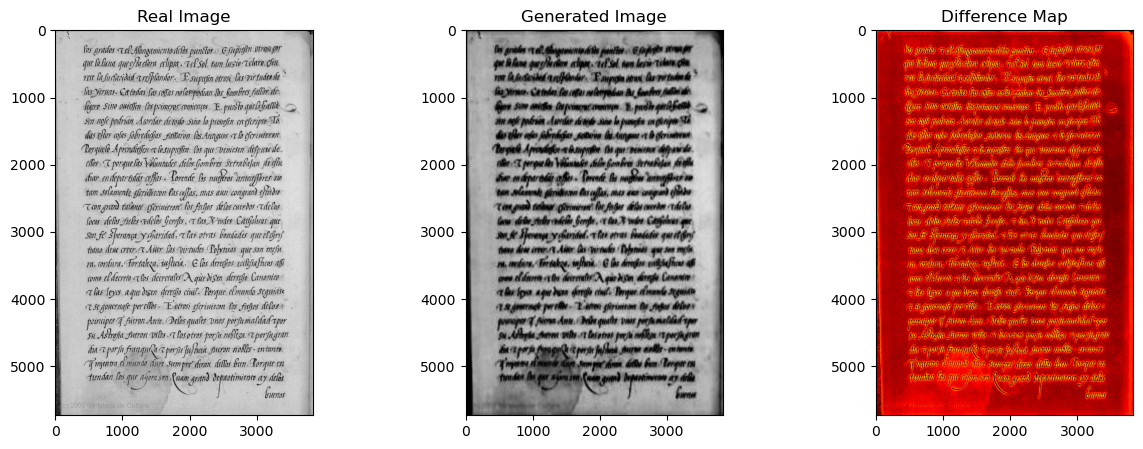

In [48]:
# 1. Image Comparisons 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()

In [49]:

ssim_scores, psnr_scores, lpips_scores = [],[],[]

loss_fn = lpips.LPIPS(net='alex') 
# Directories
real_imgs = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/"
generated_imgs = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/"

# Get sorted list of image files (ensure names match)
real_images = sorted(os.listdir(real_imgs))
generate_images = sorted(os.listdir(generated_imgs))

# Print corresponding image paths
for real, generated in zip(real_images, generate_images):
    real_img_path = os.path.join(real_imgs, real)
    generated_img_path = os.path.join(generated_imgs, generated)
    
    # Load fake and real images
    real_image = load_image(real_img_path)  
    fake_image = load_image(generated_img_path)  

    ssim_score = calculate_ssim(generated_img_path , real_img_path)
    psnr_score = calculate_psnr(real_img_path, generated_img_path)
    lpips_score = loss_fn(real_image, fake_image)
    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)
    lpips_scores.append(lpips_score)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/aniketj/anaconda3/envs/soc/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [50]:
lpips_scores = [x.item() if isinstance(x, torch.Tensor) else x for x in lpips_scores]
ssim_scores = [x.item() if isinstance(x, torch.Tensor) else x for x in ssim_scores]
psnr_scores = [x.item() if isinstance(x, torch.Tensor) else x for x in psnr_scores]


In [52]:
def compute_stats(name, data):
    mean = statistics.mean(data)
    median = statistics.median(data)
    minimum = min(data)
    maximum = max(data)
    print(f"{name}: Average = {mean:.6f}, Median = {median:.6f}, Min = {minimum:.6f}, Max = {maximum:.6f}")


compute_stats("SSIM", ssim_scores)
compute_stats("PSNR", psnr_scores)
compute_stats("LPIPS", lpips_scores)

SSIM: Average = 0.753159, Median = 0.776838, Min = 0.580901, Max = 0.871348
PSNR: Average = 27.393436, Median = 27.386749, Min = 26.969746, Max = 27.818388
LPIPS: Average = 0.260597, Median = 0.252469, Min = 0.109699, Max = 0.467809


/tmp/ipykernel_1690547/2009190697.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ssim_scores, psnr_scores, lpips_scores], labels=['SSIM', 'PSNR', 'LPIPS'])


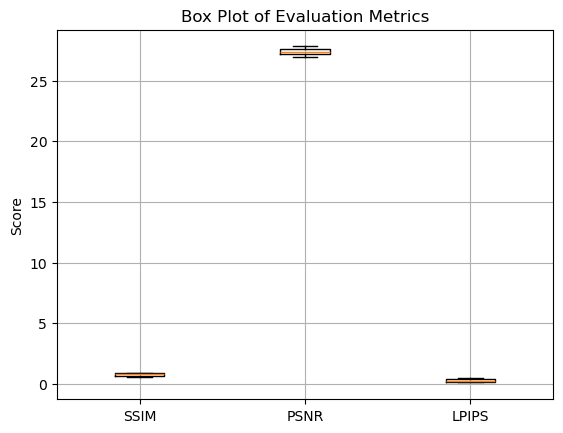

In [55]:
plt.boxplot([ssim_scores, psnr_scores, lpips_scores], labels=['SSIM', 'PSNR', 'LPIPS'])
plt.title('Box Plot of Evaluation Metrics')
plt.ylabel('Score')
plt.grid(True)
plt.show()


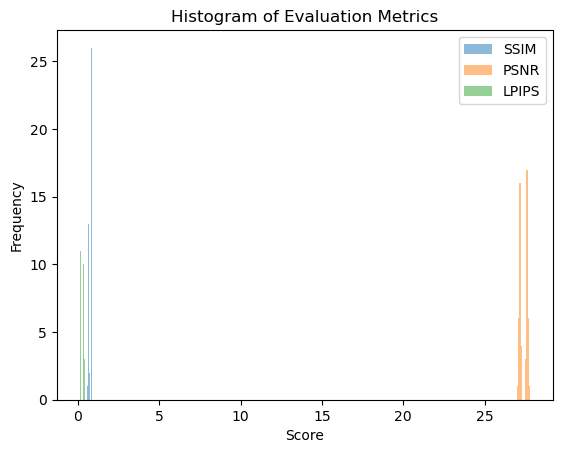

In [56]:
plt.hist(ssim_scores, bins=10, alpha=0.5, label='SSIM')
plt.hist(psnr_scores, bins=10, alpha=0.5, label='PSNR')
plt.hist(lpips_scores, bins=10, alpha=0.5, label='LPIPS')
plt.title('Histogram of Evaluation Metrics')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


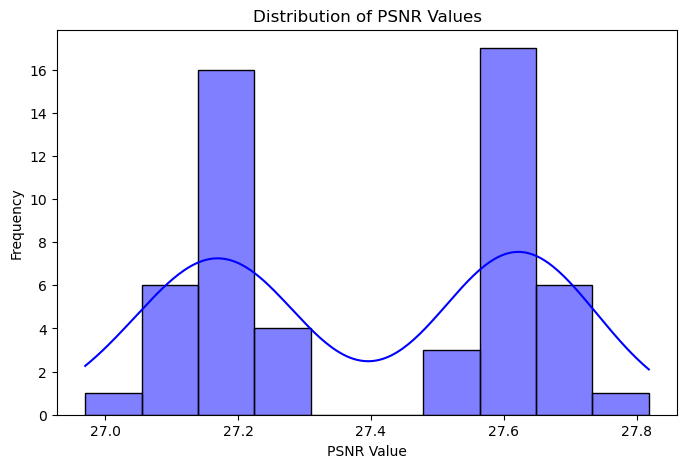

In [58]:


plt.figure(figsize=(8, 5))
sns.histplot(psnr_scores, bins=10, kde=True, color='blue')
plt.xlabel("PSNR Value")
plt.ylabel("Frequency")
plt.title("Distribution of PSNR Values")
plt.show()

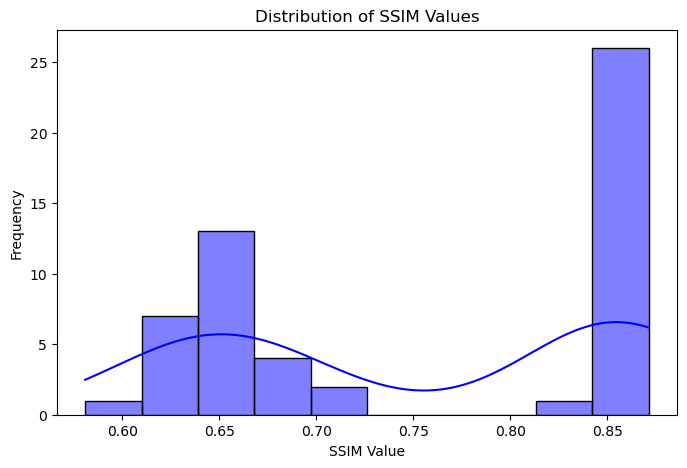

In [59]:
plt.figure(figsize=(8, 5))
sns.histplot(ssim_scores, bins=10, kde=True, color='blue')
plt.xlabel("SSIM Value")
plt.ylabel("Frequency")
plt.title("Distribution of SSIM Values")
plt.show()

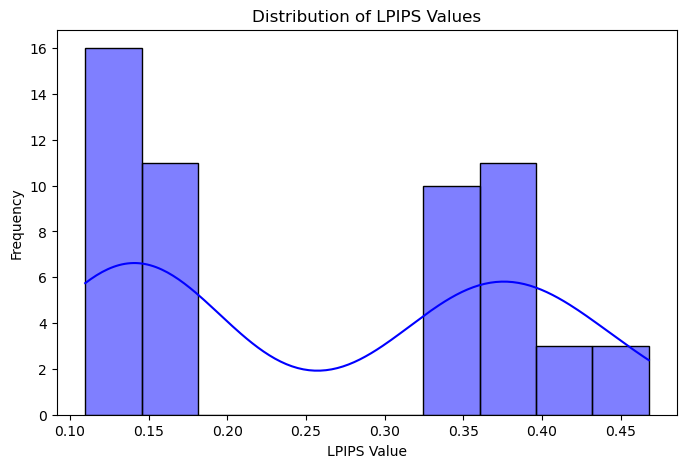

In [60]:
plt.figure(figsize=(8, 5))
sns.histplot(lpips_scores, bins=10, kde=True, color='blue')
plt.xlabel("LPIPS Value")
plt.ylabel("Frequency")
plt.title("Distribution of LPIPS Values")
plt.show()

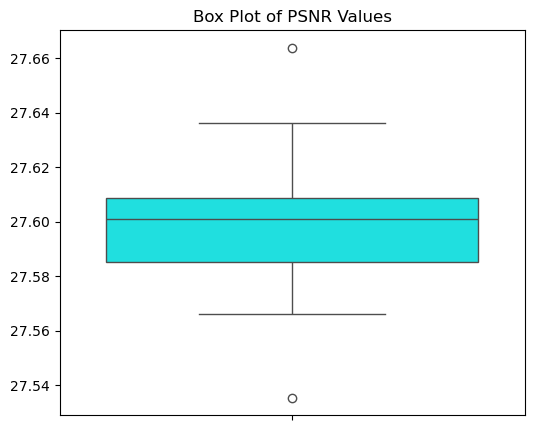

<Figure size 640x480 with 0 Axes>

In [92]:
plt.figure(figsize=(6, 5))
sns.boxplot(psnr_scores, color='cyan')
plt.title("Box Plot of PSNR Values")
plt.show()
psnr_outliers_output_path = "/home/aniketj/GSOC_TASK3/PLOTS/psnr_outliers.png"  
plt.savefig(psnr_outliers_output_path, bbox_inches="tight")


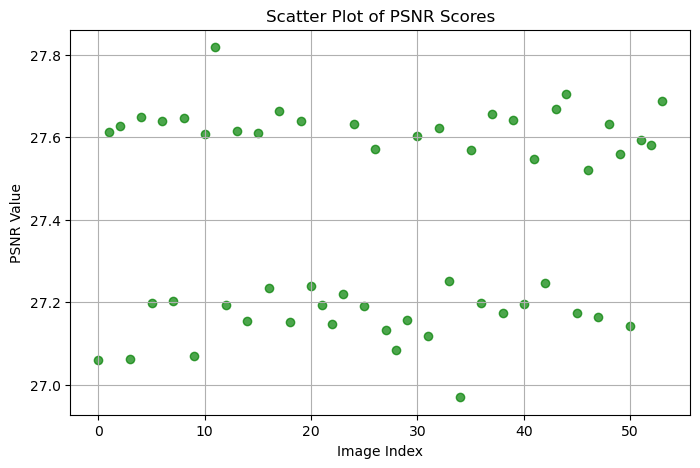

<Figure size 640x480 with 0 Axes>

In [65]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(psnr_scores)), psnr_scores, color='green', alpha=0.7)
plt.xlabel("Image Index")
plt.ylabel("PSNR Value")
plt.title("Scatter Plot of PSNR Scores")
plt.grid()
plt.show()
psnr_scatter_output_path = "/home/aniketj/GSOC_TASK3/PLOTS/psnr_scatter.png"  
plt.savefig(psnr_scatter_output_path, bbox_inches="tight")

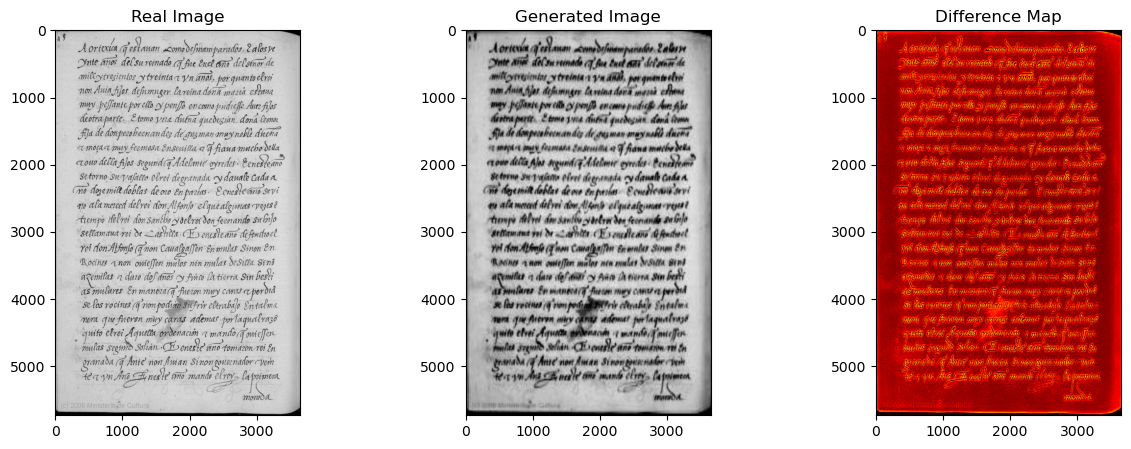

In [66]:
# Image Comparisons 
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/8.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/8.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()

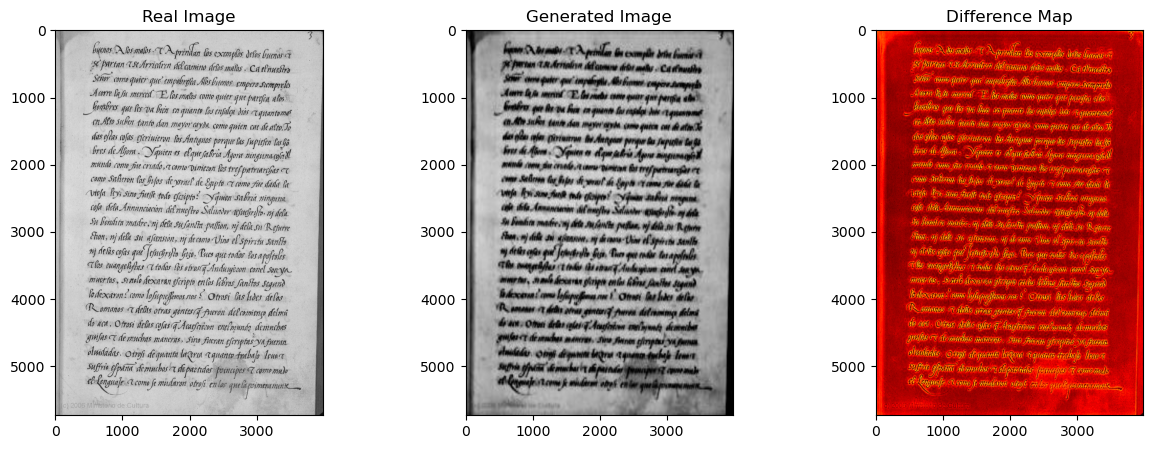

In [67]:
# Image Comparisons 
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/11.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/11.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()

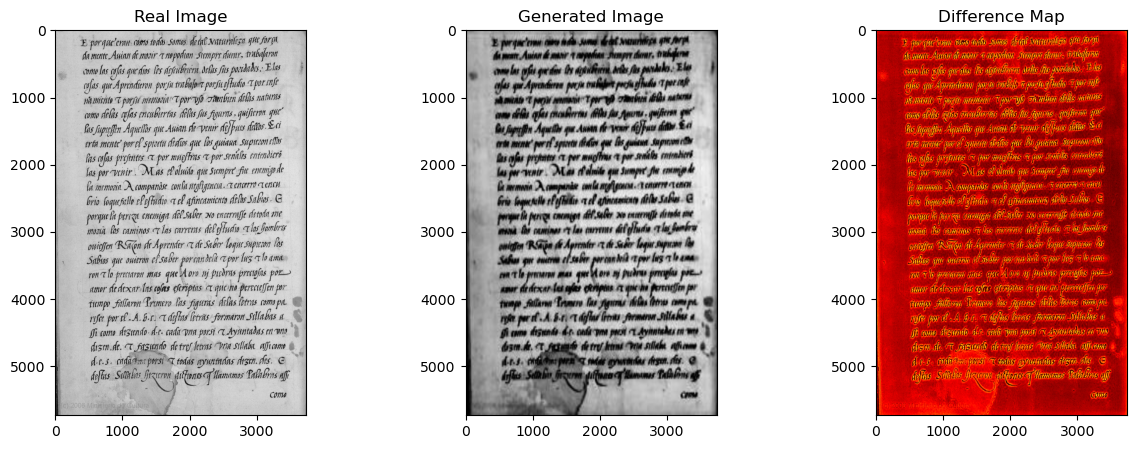

In [68]:
# Image Comparisons 
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/5.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/5.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()

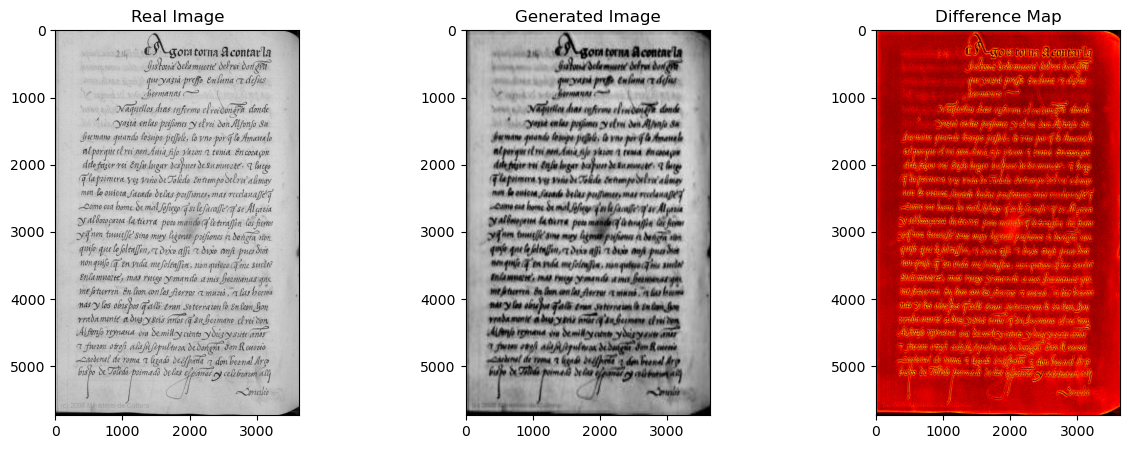

In [69]:
# Image Comparisons 
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/43.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/43.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()

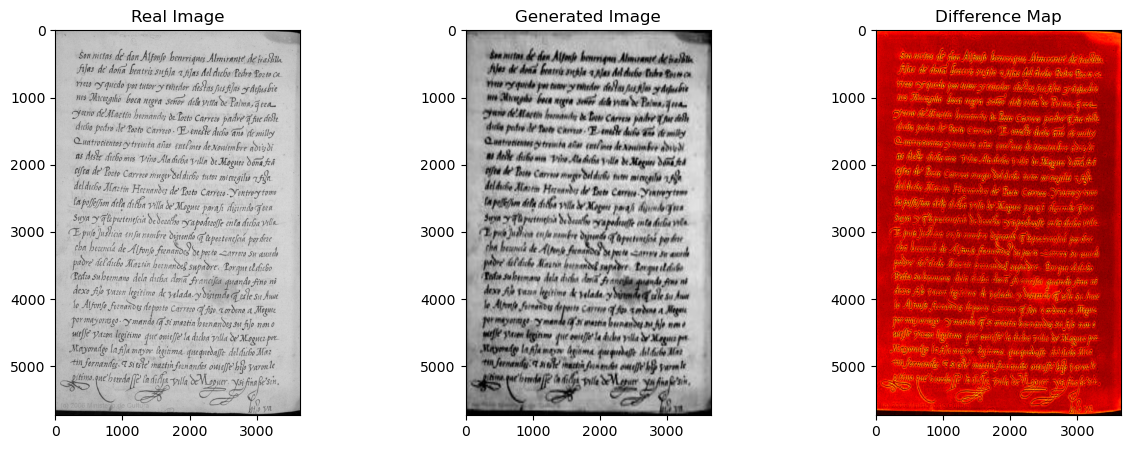

In [70]:
# Image Comparisons 
real_img_path = "/home/aniketj/GSOC_TASK3/TEST_IMAGES/49.jpg"
fake_img_path = "/home/aniketj/GSOC_TASK3/GENERATED_TEST_IMAGES/49.jpg"

real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
fake_img = cv2.imread(fake_img_path, cv2.IMREAD_GRAYSCALE)

fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(real_img, cmap='gray'); ax[0].set_title("Real Image")
ax[1].imshow(fake_img, cmap='gray'); ax[1].set_title("Generated Image")
diff = cv2.absdiff(real_img, fake_img)
ax[2].imshow(diff, cmap='hot'); ax[2].set_title("Difference Map")
plt.show()